<a href="https://colab.research.google.com/github/kaustubhadixit/BioInformatics/blob/DrugDiscovery/Drug_Discovery_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exploratory Data Analysis of Drug Discovery**

Desciptor calculation and Exlploratory data analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/bioactivity_ppd_data.csv')
df

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0,inactive
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0,intermediate
...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,10600.0,inactive
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,10100.0,inactive
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,11500.0,inactive
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,10700.0,inactive


In [6]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2021-01-06 07:16:04--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.2’

Miniconda3-py37_4.8 100%[===================>]  81.12M   275MB/s    in 0.3s    

2021-01-06 07:16:05 (275 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.2’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / - \ | / - \ | / - \ failed with initial frozen solve. Retrying with flexible solve.
Solving environment: / - \ | / - \ | / - \ | / failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: / - \ | / 

In [7]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

### **Calculating Descriptors**

Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the **druglikeness** of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the **Rule-of-Five** or **Lipinski's Rule**.

The Lipinski's Rule stated the following:

Molecular weight < 500 Dalton

Octanol-water partition coefficient (LogP) < 5

Hydrogen bond donors < 5

Hydrogen bond acceptors < 10

In [8]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [9]:
df_lipinski = lipinski(df.canonical_smiles)

In [10]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,281.271,1.89262,0.0,5.0
1,415.589,3.81320,0.0,2.0
2,421.190,2.66050,0.0,4.0
3,293.347,3.63080,0.0,3.0
4,338.344,3.53900,0.0,5.0
...,...,...,...,...
128,338.359,3.40102,0.0,5.0
129,296.366,3.44330,0.0,3.0
130,276.291,4.09564,0.0,3.0
131,278.307,3.29102,0.0,3.0


In [11]:
df_combined = pd.concat([df,df_lipinski], axis=1)
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate,281.271,1.89262,0.0,5.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate,415.589,3.81320,0.0,2.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive,421.190,2.66050,0.0,4.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0,inactive,293.347,3.63080,0.0,3.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0,intermediate,338.344,3.53900,0.0,5.0
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,10600.0,inactive,338.359,3.40102,0.0,5.0
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,10100.0,inactive,296.366,3.44330,0.0,3.0
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,11500.0,inactive,276.291,4.09564,0.0,3.0
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,10700.0,inactive,278.307,3.29102,0.0,3.0


 **Converting IC50 to pIC50**

To allow IC50 data to be more uniformly distributed, we will convert IC50 to the negative logarithmic scale which is essentially -log10(IC50).

This custom function pIC50() will accept a DataFrame as input and will:

*   Take the IC50 values from the standard_value column and converts it from nM to M by multiplying the value by 10$^{-9}$
*   Take the molar value and apply -log10

Delete the standard_value column and create a new pIC50 colum

In [12]:
def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [13]:
df_combined.standard_value.describe()

count    1.330000e+02
mean     8.017926e+12
std      3.344888e+13
min      5.000000e+01
25%      1.070000e+04
50%      2.350000e+04
75%      3.000000e+05
max      3.311311e+14
Name: standard_value, dtype: float64

In [14]:
-np.log10( (10**-9)* 100000000 )

1.0

In [15]:
-np.log10( (10**-9)* 10000000000 )

-1.0

In [16]:

def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

In [17]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediate,281.271,1.89262,0.0,5.0,7200.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediate,415.589,3.81320,0.0,2.0,9400.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,13500.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,13110.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediate,338.344,3.53900,0.0,5.0,2000.0
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0.0,5.0,10600.0
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0.0,3.0,10100.0
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0.0,3.0,11500.0
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0.0,3.0,10700.0


In [18]:
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediate,281.271,1.89262,0.0,5.0,5.142668
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediate,415.589,3.81320,0.0,2.0,5.026872
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,4.882397
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediate,338.344,3.53900,0.0,5.0,5.698970
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0.0,5.0,4.974694
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0.0,3.0,4.995679
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0.0,3.0,4.939302
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0.0,3.0,4.970616


**Let us remove the intermediate class from the dataframe**

In [20]:
df_woint = df_final[df_final.bioactivity_class != 'intermediate']
df_woint

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,4.882397
5,CHEMBL365134,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c(Br)cccc21,active,372.243,4.39330,0.0,3.0,6.008774
7,CHEMBL190743,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccc(I)cc21,active,419.243,4.23540,0.0,3.0,6.022276
8,CHEMBL365469,O=C1C(=O)N(Cc2cc3ccccc3s2)c2cccc(Cl)c21,inactive,327.792,4.28420,0.0,3.0,4.950782
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0.0,5.0,4.974694
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0.0,3.0,4.995679
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0.0,3.0,4.939302
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0.0,3.0,4.970616


## **Chemical Space Analysis via Lipinski descriptors**

In [21]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

**Frequency plot of bioactivity classes**

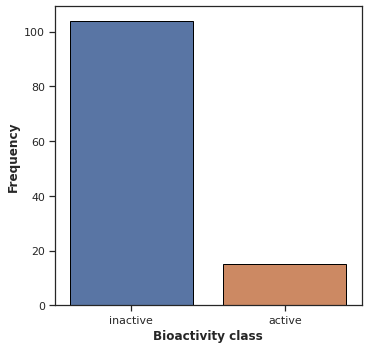

In [24]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_woint, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')


**Scatter Plot of Molecular wight vs LogP**
They are spanning similar chemical spaces

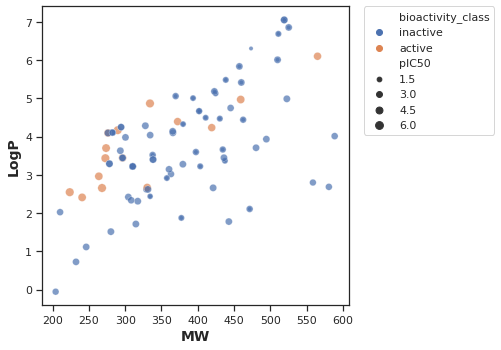

In [25]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_woint, hue='bioactivity_class', size='pIC50', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

# MW

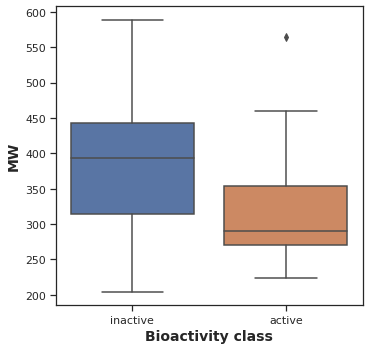

In [27]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_woint)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

#pIC50

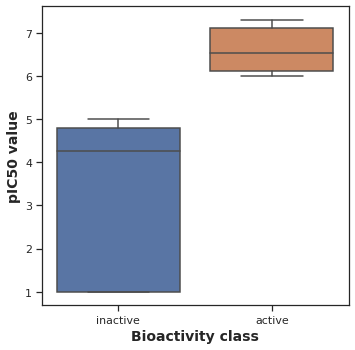

In [29]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = df_woint)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

# LogP

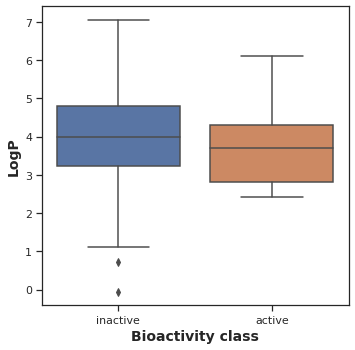

In [31]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_woint)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

# NumHDonors

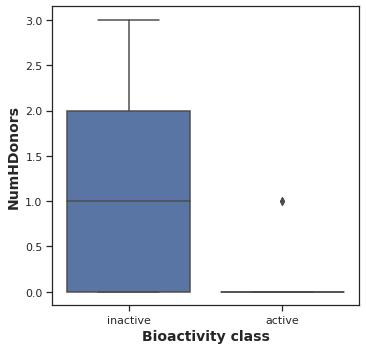

In [33]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_woint)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

# NumHAcceptors

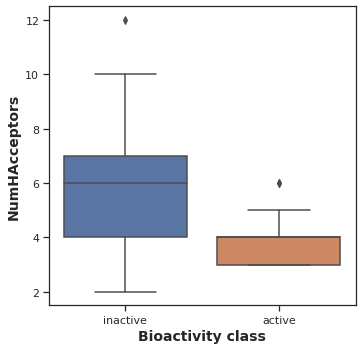

In [34]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data = df_woint)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

# Statistical analysis using Mann-Whitney U test
https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/

In [35]:
def mannwhitney(descriptor, verbose=False):
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_woint[selection]
  active = df[df.bioactivity_class == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_woint[selection]
  inactive = df[df.bioactivity_class == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

#MannWhitney tests

In [36]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,409.5,0.001525,0.05,Different distribution (reject H0)


In [37]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,0.0,1.662636e-10,0.05,Different distribution (reject H0)


In [38]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,712.5,0.295805,0.05,Same distribution (fail to reject H0)


In [40]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,299.5,0.000024,0.05,Different distribution (reject H0)


In [42]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,415.0,0.001557,0.05,Different distribution (reject H0)


# **Interpretation of Statistical Results**
**Lipinski Descriptors**

Out of the four descriptors, only **LogP** exhibited **same distribution** between actives and inactives while other three MW, NumHDonors and NumHAcceptors shows **statistically significant difference** between actives and inactives

